## Libraries

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from stop_words import get_stop_words
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, confusion_matrix, classification_report, make_scorer  # noqa: E501
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

## EDA

In [2]:
df = pd.read_csv('reviews.csv')
df.head()

,hotel_name,processed_review,date_stayed,trip_type,processed_rating
0,Fairmont Austin,great service and food sebastian was our serve...,August 2023,with family,50
1,Fairmont Austin,the gold level service was incredible i hate w...,February 2023,with family,50
2,Fairmont Austin,fantastic experience over batfest weekend firs...,August 2023,as a couple,50
3,Fairmont Austin,excellent service great amenities my husband a...,August 2023,on business,50
4,Fairmont Austin,fabulous feet from awesome pedicure i had a pe...,August 2023,on business,50


##### Create new column "rating" based on 50 to 5.0, and so on
##### Creating new column "churn" based on if "processed_rating" is > 35

In [3]:
df['rating'] = df['processed_rating']/10
df['churn'] = df['rating'].apply(lambda x: 'non-churn' if x > 3.5 else 'churn')
df.head()

,hotel_name,processed_review,date_stayed,trip_type,processed_rating,rating,churn
0,Fairmont Austin,great service and food sebastian was our serve...,August 2023,with family,50,5.0,non-churn
1,Fairmont Austin,the gold level service was incredible i hate w...,February 2023,with family,50,5.0,non-churn
2,Fairmont Austin,fantastic experience over batfest weekend firs...,August 2023,as a couple,50,5.0,non-churn
3,Fairmont Austin,excellent service great amenities my husband a...,August 2023,on business,50,5.0,non-churn
4,Fairmont Austin,fabulous feet from awesome pedicure i had a pe...,August 2023,on business,50,5.0,non-churn


Text(0.5, 1.0, 'Review Count by Rating')

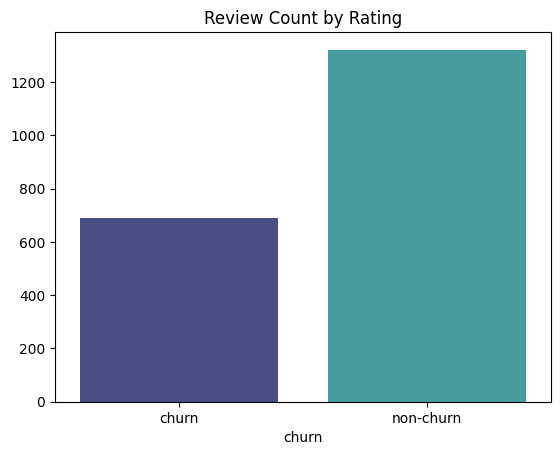

In [4]:
grouped = df.groupby('churn')['churn'].count()
sns.barplot(x = grouped.index, y = grouped.values, palette='mako').set_title('Review Count by Rating')

## Tokenize "processed_review"

In [5]:
sw = stopwords.words('english')

def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def doc_preparer(doc, stop_words=sw):
    
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    doc = regex_token.tokenize(doc)
    doc = [word.lower() for word in doc]
    doc = [word for word in doc if word not in sw]
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    return ' '.join(doc)

df['tokenized_review'] = df['processed_review'].apply(doc_preparer)

## Pre-modeling - Train Test Split

In [6]:
X = df['tokenized_review']
y = df['churn']

X_train, X_test, y_train, y_test =  train_test_split(X, y, train_size= .7, random_state= 760397, stratify = y)

## Vectorizing
Cutting off the top 10% and bottom 5% of words in vectorized documents to keep the more meaningful words.

In [7]:
tfidf_train = TfidfVectorizer(sublinear_tf=True, max_df=.9, min_df=.05,  ngram_range=(1, 1))
train_features = tfidf_train.fit_transform(X_train).toarray()
test_features = tfidf_train.transform(X_test).toarray()

# wm = tfidf_train.fit_transform(X_train)
# tokens = tfidf_train.get_feature_names_out()

# wm.shape
# doc_names = ['Doc{:d}'.format(idx) for idx, _ in enumerate(wm)]
# data = pd.DataFrame(data=wm.toarray(), index=doc_names,
#                   columns=tokens)
# data.mean().sort_values()

## PCA

In [8]:
pca = PCA(n_components=0.9, random_state=1)

pca_train = pca.fit_transform(train_features)
pca_test = pca.transform(test_features)

## Modeling

##### Evaluation Function

In [9]:
def metrics_score(train_preds, y_train, test_preds, y_test):
    print(f"Training Accuracy:\t{accuracy_score(y_train, train_preds):.4}",
          f"\tTesting Accuracy:\t{accuracy_score(y_test, test_preds):.4}")
    print(f"Training Precision:\t{precision_score(y_train, train_preds, average='weighted'):.4}",
          f"\tTesting Precision:\t{precision_score(y_test, test_preds, average='weighted'):.4}")
    print(f"Training Recall:\t{recall_score(y_train, train_preds, average='weighted'):.4}",
          f"\tTesting Recall:\t\t{recall_score(y_test, test_preds, average='weighted'):.4}")
    print(f"Training F1:\t\t{f1_score(y_train, train_preds, average='weighted'):.4}",
          f"\tTesting F1:\t\t{f1_score(y_test, test_preds, average='weighted'):.4}")

## Logistic Regression
Pipelining standard scaler and params of logistic regression

In [10]:
pipe = Pipeline(steps=[('STD_SCALER', MinMaxScaler()),
                       ('LR', linear_model.LogisticRegression(class_weight='balanced', random_state=760397))])

params = dict(LR__C=np.logspace(0, 1, 10), 
              LR__max_iter=[100],
              LR__penalty=['none', 'l2'])

LR_PCA_grid_search = GridSearchCV(estimator = pipe,
                                  scoring = make_scorer(f1_score, average='weighted'), 
                                  param_grid = params, 
                                  cv = 5, n_jobs = -1, verbose = 2)

LR_PCA_grid_search.fit(pca_train, y_train)
# LR_PCA_train_preds = LR_PCA_grid_search.best_estimator_.predict(pca_train)
LR_PCA_test_preds = LR_PCA_grid_search.best_estimator_.predict(pca_test)
# metrics_score(LR_PCA_train_preds, y_train, LR_PCA_test_preds, y_test)
print("Best params: " + str(LR_PCA_grid_search.best_params_))

# Confusion Matrix
print(confusion_matrix(y_test, LR_PCA_test_preds).T)
# sns.heatmap(confusion_matrix(y_test, LR_PCA_test_preds).T,
#             square=True,
#             annot=True,
#             fmt='d',
#             cmap="rocket_r",
#             linewidths=1).set_title('Confusion Matrix', fontsize=30)

# Classification Report
print(classification_report(y_test, LR_PCA_test_preds))

# Fit the TfidfVectorizer separately
tfidf_vectorizer = tfidf_train
train_features_tfidf = tfidf_vectorizer.fit_transform(X_train)
test_features_tfidf = tfidf_vectorizer.transform(X_test)

# FEATURE IMPORTANCE
# Fit the optimal logistic regression model
logistic_pipe = linear_model.LogisticRegression(C=LR_PCA_grid_search.best_params_['LR__C'],
                                                max_iter=LR_PCA_grid_search.best_params_['LR__max_iter'],
                                                penalty=LR_PCA_grid_search.best_params_['LR__penalty'],
                                                class_weight='balanced',
                                                random_state=760397)
lr_model = logistic_pipe.fit(train_features_tfidf, y_train)

# Get the coefficients of the LR model
lr_coefficients = lr_model.coef_[0]

# Get the feature names from the TfidfVectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Create a DataFrame to store feature names and their corresponding coefficients
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': lr_coefficients})

# Sort the DataFrame by coefficient magnitude to get feature importance
sorted_feature_importance = feature_importance_df.sort_values(by='Coefficient', ascending=False)

# Print the top feature importance values along with the corresponding words
print("Top 10 POSITIVE Features by Importance:")
for index, row in sorted_feature_importance.head(10).iterrows():
    feature_word = row['Feature']
    coefficient = row['Coefficient']
    print(f"Word: {feature_word}\tCoefficient: {coefficient}")

print('\n')

print("Top 10 NEGATIVE Features by Importance:")
for index, row in sorted_feature_importance.tail(10).iterrows():
    feature_word = row['Feature']
    coefficient = row['Coefficient']
    print(f"Word: {feature_word}\tCoefficient: {coefficient}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best params: {'LR__C': 1.0, 'LR__max_iter': 100, 'LR__penalty': 'l2'}
[[182  49]
 [ 25 348]]
              precision    recall  f1-score   support

       churn       0.79      0.88      0.83       207
   non-churn       0.93      0.88      0.90       397

    accuracy                           0.88       604
   macro avg       0.86      0.88      0.87       604
weighted avg       0.88      0.88      0.88       604

Top 10 POSITIVE Features by Importance:
Word: great	Coefficient: 4.551379903194395
Word: austin	Coefficient: 2.976765962782513
Word: helpful	Coefficient: 2.8891227211438433
Word: wonderful	Coefficient: 2.6249945357814712
Word: excellent	Coefficient: 2.617987440877126
Word: perfect	Coefficient: 2.5812470774927703
Word: love	Coefficient: 2.2747705346564135
Word: amaze	Coefficient: 2.2094499619146233
Word: enjoy	Coefficient: 2.1924662710816873
Word: comfortable	Coefficient: 2.1081093825081076


Top 10 NEGATIVE Featu

## Random Forest

In [11]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(random_state=760397,
                                       class_weight='balanced')

pipe = Pipeline(steps=[
    ('STD_SCALER', MinMaxScaler()),
    ('RF', rf_classifier)
])

params = {
    # 1st CV
    # 'RF__max_features':['auto', 'sqrt', 'log2', None],
    # 'RF__n_estimators': [300, 500, 700, 900, 1100, 1300]
    
    # 2nd CV
    # 'RF__max_features':[None],
    # 'RF__n_estimators': [200, 300, 400],
    # 'RF__criterion': ['entropy', 'gini'],
    # 'RF__max_depth': [7, 9, 11, 13, 15, None]

    # 3rd CV
    # 'RF__max_features':[None],
    # 'RF__n_estimators': [100, 200, 300],
    # 'RF__criterion': ['gini'],
    # 'RF__max_depth': [12, 13, 14]

    # 4th CV
    # 'RF__max_features':[None],
    # 'RF__n_estimators': [200],
    # 'RF__criterion': ['gini'],
    # 'RF__max_depth': [13],
    # 'RF__min_samples_leaf': [1, 3, 5, 7],
    # 'RF__min_samples_split': [2, 4, 6, 8]

    # 5th CV
    'RF__max_features':[None],
    'RF__n_estimators': [200],
    'RF__criterion': ['gini'],
    'RF__max_depth': [13],
    'RF__min_samples_leaf': [1],
    'RF__min_samples_split': [2],
    'RF__class_weight':[{'churn':1, 'non-churn':1}, 
                        {'churn':1, 'non-churn':2}, 
                        {'churn':1, 'non-churn':3}]
}

RF_PCA_grid_search = GridSearchCV(
    estimator=pipe,
    scoring=make_scorer(f1_score, average='weighted'),
    param_grid=params,
    cv=5, n_jobs=-1, verbose=2
)

RF_PCA_grid_search.fit(pca_train, y_train)
RF_PCA_train_preds = RF_PCA_grid_search.best_estimator_.predict(pca_train)
RF_PCA_test_preds = RF_PCA_grid_search.best_estimator_.predict(pca_test)

print('\n')
# metrics_score(RF_PCA_train_preds, y_train, RF_PCA_test_preds, y_test)
print("Best params: " + str(RF_PCA_grid_search.best_params_))
print(confusion_matrix(y_test, RF_PCA_test_preds).T)
print(classification_report(y_test, RF_PCA_test_preds))

# FEATURE IMPORTANCE
# Fit the optimal logistic regression model
RF_pipe = RandomForestClassifier(class_weight=RF_PCA_grid_search.best_params_['RF__class_weight'],
                                 criterion=RF_PCA_grid_search.best_params_['RF__criterion'],
                                 max_depth=RF_PCA_grid_search.best_params_['RF__max_depth'],
                                 max_features=RF_PCA_grid_search.best_params_['RF__max_features'],
                                 min_samples_leaf=RF_PCA_grid_search.best_params_['RF__min_samples_leaf'],
                                 min_samples_split=RF_PCA_grid_search.best_params_['RF__min_samples_split'],
                                 n_estimators=RF_PCA_grid_search.best_params_['RF__n_estimators'],
                                 n_jobs=-1, random_state=760397)
RF_model = RF_pipe.fit(train_features_tfidf, y_train)

# Get the feature importances
feature_importances = RF_model.feature_importances_

# Get the feature names from the TfidfVectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Create a DataFrame to store feature names and their corresponding importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the DataFrame by importance magnitude to get feature importance
sorted_feature_importance = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the top feature importance values along with the corresponding words
print("Top 10 POSITIVE Features by Importance:")
for index, row in sorted_feature_importance.head(10).iterrows():
    feature_word = row['Feature']
    importance = row['Importance']
    print(f"Word: {feature_word}\tImportance: {importance}")

print("Top 10 NEGATIVE Features by Importance:")
for index, row in sorted_feature_importance.tail(10).iterrows():
    feature_word = row['Feature']
    importance = row['Importance']
    print(f"Word: {feature_word}\tImportance: {importance}")


Fitting 5 folds for each of 3 candidates, totalling 15 fits


Best params: {'RF__class_weight': {'churn': 1, 'non-churn': 3}, 'RF__criterion': 'gini', 'RF__max_depth': 13, 'RF__max_features': None, 'RF__min_samples_leaf': 1, 'RF__min_samples_split': 2, 'RF__n_estimators': 200}
[[150  33]
 [ 57 364]]
              precision    recall  f1-score   support

       churn       0.82      0.72      0.77       207
   non-churn       0.86      0.92      0.89       397

    accuracy                           0.85       604
   macro avg       0.84      0.82      0.83       604
weighted avg       0.85      0.85      0.85       604

Top 10 POSITIVE Features by Importance:
Word: bad	Importance: 0.10789014152079483
Word: call	Importance: 0.07789673397715358
Word: great	Importance: 0.0681150106910451
Word: tell	Importance: 0.06238404514036968
Word: room	Importance: 0.04769926152102748
Word: door	Importance: 0.043751799593159744
Word: never	Importance: 0.03957103216265344
Word: floor	Importance: 0.0197

## Predicting A New Review

In [12]:
# 3rd entry of reviews.csv
title = "The Gold level service was incredible"
review = "I hate writing reviews but this experience was so good I couldn't not. A big reason is that we left something in the room at check out and the staff found it and has kept it for us. We booked to stay for seven nights in a one bedroom with our two young daughters on the gold level which was the best idea. From the doorman who shuttled us to the gold level where we were able to check in while the kids enjoyed refreshments after a long travel day to the staff in the lunch itself who revealed a games cabinet. We loved it so much (and it was snowing back home) we stayed another four nights in the Grand Suite which was even better. It was huge and came with its own kitchen! Without going to long, the pool was always warm, the drinks were always cold, and the staff was always…"
# non-churn

In [13]:
# Random 1 star review
title = "Worst hotel ever!!"
review = "Horrible experience. Horrible. Upon walking into the room it was hot, sticky and smelled bad-musty. There were two hard, crusty stains on the carpet that they had hardly even tried to clean up, the carpet overall was dirty. The shower leaked and the toilet sounded like a screaming jet engine. They have absolutely no channels on the tv. Their WiFi was trash. The pillows, sheets and comforter smelled old and like someone else’s sweat. They advertise and tell you at check in that they have in room services such as food but they do not. We couldn’t even get bottled water, which was horrid after being on a plane for 10 hours to get there —-we were thirsty. The walls are paper thin so you hear everything including people yelling all night. The rooms are not clean, there is an inch…"
# churn

In [14]:
# Chat-GPT POSITIVE review using negative words (new chat)
title = """An Unforgettable Hotel Experience: Love It or... "Love" It More?"""
review = """Let me tell you about my recent stay at this hotel, which was an experience I won't soon forget. From the moment I arrived, I was greeted with a level of "uniqueness" that I can only describe as "hatefully unforgettable."

Let's delve into the rooms, shall we? The term "cozy" takes on a whole new meaning here. It's like they've redefined the concept of personal space to mean "nonexistent." If you're someone who "loves" the idea of having to navigate around furniture with the precision of a tightrope walker, then you're in for a treat.

The staff – oh, where do I begin with them? Their "enthusiasm" is truly something to behold, especially if you have a passion for witnessing people who take customer service to a whole new level of "uncontainable enthusiasm." It's almost as if they're on a mission to make you question your own sanity.

And let's not forget the dining experience. The menu is a masterclass in "unconventional" culinary choices. Each dish seems to be an experiment in combining ingredients that were never meant to meet. If you've ever "hated" the idea of a meal making logical sense, this place will reaffirm your beliefs.

As for the hotel's interior design, it's a "worse" version of eclectic. The clash of "vintage" and "modern" elements creates an atmosphere that can only be described as "hatefully fascinating." It's like someone picked out pieces from various time periods blindfolded and hoped for the best.

In conclusion, if you're the type of person who relishes in the idea of an experience that you'll "love" to recount as the epitome of the word "unique," then this hotel should be at the top of your list. It's a "worse" nightmare for those who appreciate the conventional, and a "hateful" dream for those who live for the offbeat."""
# churn


In [15]:
# Chat-GPT NEGATIVE review using positive words (new chat2)
title = "Absolutely loved my stay at this hotel."
review = "The incredible attention to detail was mind-boggling - from the exquisitely clean and spacious room to the overly friendly and accommodating staff who just wouldn't give me a moment of peace. And let's not forget the endless array of amenities that made me feel like I was drowning in luxury. The breathtaking view from my window was such a distraction that I couldn't even concentrate on my work. And the food? Oh, don't even get me started on the gourmet meals that left me in a state of constant overindulgence. I must say, I was utterly overwhelmed by the constant pampering and care. Can't wait to never stay here again!"
# churn (false positive but this text from Chat-GPT is weird)

In [16]:
# 2nd Chat-GPT POSITIVE review using negative words (used chat2)
title = "I must admit, my stay at this hotel was quite the experience."
review = "The room I was assigned was a real masterpiece of inconvenience and discomfort. The bed felt like a slab of concrete designed to challenge my ability to sleep, and the lack of air conditioning turned the room into a cozy sauna, perfect for a hot yoga session. The staff, bless their hearts, were always available to chat, making it nearly impossible for me to have a moment of solitude. The view from my window showcased the bustling construction site next door, providing a constant reminder of urban chaos. And the food? Well, let's just say that my taste buds were treated to a symphony of unique flavors that I won't soon forget – mostly because they were all so incredibly unappetizing. Despite these minor setbacks, I truly appreciated the hotel's commitment to providing an unforgettable and character-building stay."
# non-churn

In [17]:
# 3rd Chat-GPT POSITIVE review using negative words (new chat3)
title = """A Diamond in the Rough"""
review = """I recently had the opportunity to stay at this hotel, and I must admit, I was initially taken aback by some minor aspects. However, as my stay progressed, I realized that there's much more to this place than meets the eye.

While the check-in process seemed a bit slow due to a sudden influx of guests, the staff managed to handle the situation with remarkable poise and professionalism. Despite a momentary inconvenience, their attentive demeanor turned my initial frustration into admiration for their dedication to ensuring a smooth experience for everyone.

The room I was assigned had a quaint charm to it, although it appeared to be in need of a little updating. But what truly caught my attention was the impeccable cleanliness – it was evident that the housekeeping team took their responsibilities seriously. Although the view from the window was less than spectacular, I found solace in the serenity and comfort that the room provided.

The dining experience had its hiccups, with a limited menu that left me wanting more variety. Nevertheless, the flavors of the dishes served were quite delightful. The restaurant staff, while a bit overwhelmed, managed to provide a warm and welcoming atmosphere that made me feel right at home.

One area that could use improvement is the spa facilities. The offerings were somewhat underwhelming, and I had hoped for a more extensive range of treatments. However, the therapists displayed expertise and skill, making the spa visit a rejuvenating experience despite the limited options.

All in all, my stay at this hotel was a valuable lesson in looking beyond initial impressions. The challenges I encountered were overshadowed by the exceptional efforts of the staff, who went above and beyond to ensure my comfort. With a few adjustments, this hotel has the potential to become an absolute gem in the hospitality industry. I left with a sense of gratitude for the positive aspects that shone through the initial setbacks, and I look forward to witnessing the growth of this establishment in the future."""
# non-churn

In [18]:
# 4th Chat-GPT POSITIVE review using negative words (new chat4)
title = ""
review = "I must admit, my initial impression of the hotel wasn't the best due to a minor delay during check-in, which left me slightly frustrated. However, I'm delighted to share that the rest of my stay completely turned things around. The staff went above and beyond to rectify the situation, ensuring that my room was not only spacious and comfortable but also impeccably clean. I was pleasantly surprised by the variety of dining options available, which more than made up for the initial inconvenience. Additionally, the central location of the hotel meant that I had easy access to all the attractions I wanted to visit. While the start might not have been perfect, the exceptional service and overall experience definitely won me over."
# non-churn

In [19]:
# START ALGORITHM
# Define a list of stop words
stop_words = list(get_stop_words('en'))  # About 900 stopwords
nltk_words = list(stopwords.words('english'))  # About 150 stopwords
punctuations = [".", "'", ","]
stop_words.extend(nltk_words + punctuations)

# Replicating the raw scraped-review text
reviewWithTitle = " ".join((title.strip(), review.strip()))  # noqa: E501

# Replicating the tokenizing
tokenizer = RegexpTokenizer(r'\w+')
word_list = tokenizer.tokenize(reviewWithTitle.lower())
output = [w for w in word_list if not w in stop_words]  # noqa: E501
new_review = ' '.join(word_list)
print(new_review)
# Create blank dataframe for new_review
df2 = pd.DataFrame(['new_review'])
df2['new_review'] = new_review
tokenized_new_review = df2['new_review'].apply(doc_preparer)

# Replicating the vectorizing
new_test_features = tfidf_train.transform(tokenized_new_review).toarray()

# Replicating the pca
new_pca_test = pca.transform(new_test_features)

# Using the optimal LR model to predict our new review
# new_preds = LR_PCA_grid_search.best_estimator_.predict(new_pca_test)
new_preds = RF_PCA_grid_search.best_estimator_.predict(new_pca_test)

# Print prediction
print(new_preds)

i must admit my initial impression of the hotel wasn t the best due to a minor delay during check in which left me slightly frustrated however i m delighted to share that the rest of my stay completely turned things around the staff went above and beyond to rectify the situation ensuring that my room was not only spacious and comfortable but also impeccably clean i was pleasantly surprised by the variety of dining options available which more than made up for the initial inconvenience additionally the central location of the hotel meant that i had easy access to all the attractions i wanted to visit while the start might not have been perfect the exceptional service and overall experience definitely won me over
['non-churn']


## Word Clouds

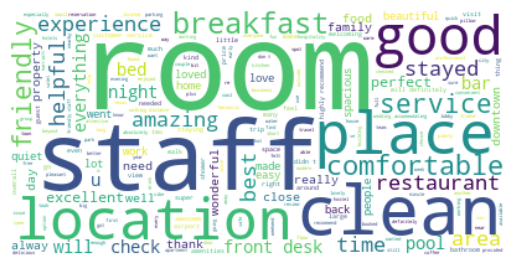

In [54]:
# Non-churn reviews, general manager needs to reply with thanks
# Create stopword list:
stopwords = set(STOPWORDS)

# UPDATE THIS WITH WORDS THAT ARE USELESS
# subject of the reviews "hotel"
# city of hotels "austin"
# random 1 letter words
stopwords.update(["hotel", "austin", "s", "stay", "great", "nice", "one"])

# Combine all non-churn review texts
positive_reviews = " ".join(review for review in df.processed_review[df.churn == 'non-churn'])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(positive_reviews)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


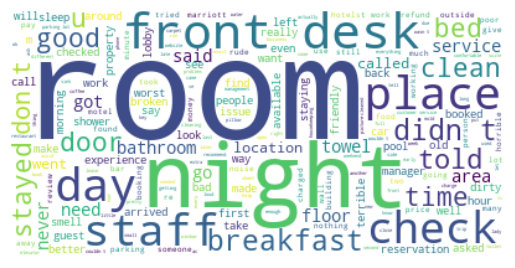

In [55]:
# CHURN REVIEWS
# Combine all non-churn review texts
positive_reviews = " ".join(review for review in df.processed_review[df.churn == 'churn'])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(positive_reviews)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

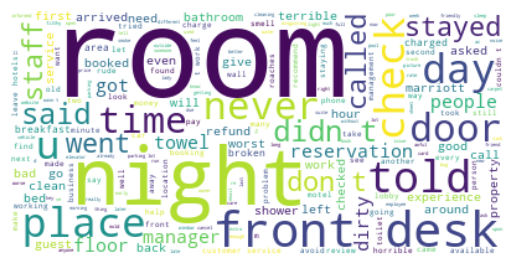

In [56]:
# 1 STAR REVIEWS, customers very likely do not recommend
# Combine all non-churn review texts
positive_reviews = " ".join(review for review in df.processed_review[df.processed_rating == 10])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(positive_reviews)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

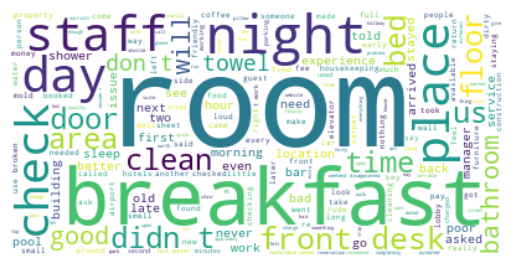

In [57]:
# 2 STAR REVIEWS, customer's majority of experience is negative
# Combine all non-churn review texts
positive_reviews = " ".join(review for review in df.processed_review[df.processed_rating == 20])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(positive_reviews)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

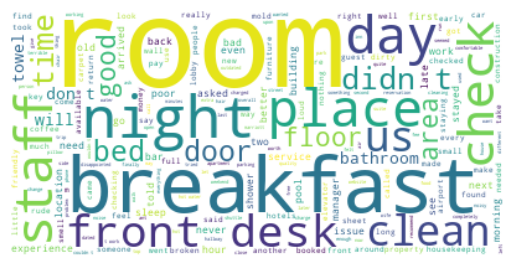

In [58]:
# 3 STAR REVIEWS, customer states hotel is average
# Combine all non-churn review texts
positive_reviews = " ".join(review for review in df.processed_review[df.processed_rating == 20])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(positive_reviews)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

https://www.datacamp.com/tutorial/wordcloud-python